# Estimacion de Fase Cuantico

## Implementacion en un qubit de control

Recordemos el circuito cuantico
![A single-qubit circuit for phase-estimation](images/estimate-phase-with-kickback.png)

La idea es codificar la informacion del valor de fase $theta$ en la amplitud, en la probilidad de obtener $\vert0\rangle$ y $\vert1\rangle$

Podemos calcular la lista de probabilidades de las posibles medidas dependiendo del valor de $\theta$.

| $\theta$ | $\cos^2(\pi\theta)$ | $\sin^2(\pi\theta)$ |
| :--: | :--: | :--: |
| 0.0000 | 1.0000 | 0.0000 |
| 0.1250 | 0.8536 | 0.1464 |
| 0.2500 | 0.5000 | 0.5000 |
| 0.3750 | 0.1464 | 0.8536 |
| 0.5000 | 0.0000 | 1.0000 |
| 0.6250 | 0.1464 | 0.8536 |
| 0.7500 | 0.5000 | 0.5000 |
| 0.8750 | 0.8536 | 0.1464 |

Si graficamos las probabilidades de obtener $0$ and $1$ dependiendo del valor de $theta$ obtenemos:

![Outcome probabilities from phase kickback](images/kickback-probabilities.png)


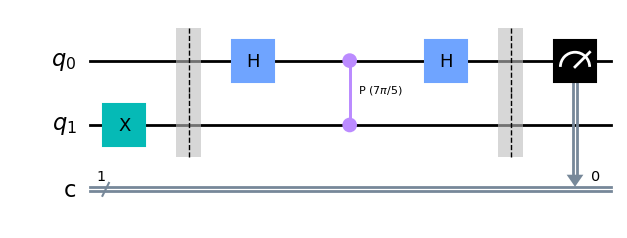

In [3]:
from math import pi, cos, sin
from qiskit import QuantumCircuit

theta = 0.7 # Can be changed to any value between 0 and 1

qc = QuantumCircuit(2, 1)

# Prepare eigenvector, which is the |1> state

qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2*pi*theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

# Draw the circuit
qc.draw(output="mpl")

Corremos el circuito

In [4]:
from qiskit.primitives import Sampler
Sampler().run(qc).result()

SamplerResult(quasi_dists=[{0: 0.3454915028125262, 1: 0.6545084971874736}], metadata=[{}])

Ahora comparemoslo con la evaluacion de la funcion

In [5]:
{   # Calculate predicted results
    0: cos(pi * theta) ** 2, 
    1: sin(pi * theta) ** 2
}

{0: 0.34549150281252616, 1: 0.6545084971874737}

## Implementacion en multiples qubits

Recordemos el circuito cuantico para realizar la estimacion de fase:
![Phase estimation procedure](images/phase-estimation-procedure.png)


### Empecemos por implementar el circuito en dos qubits de control

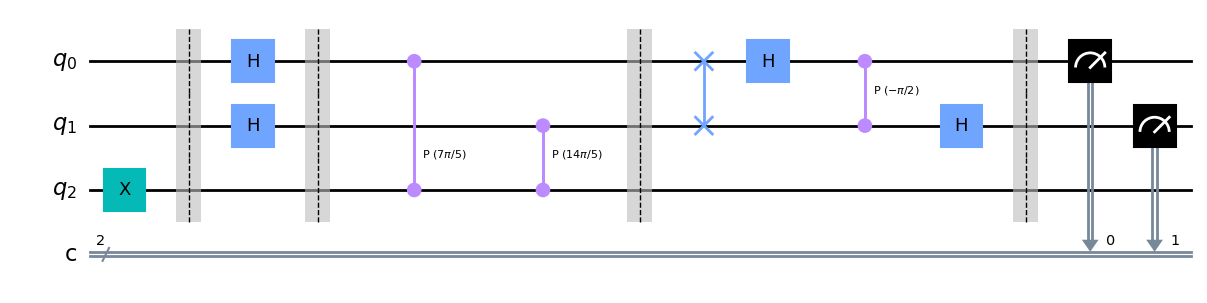

In [13]:
from math import pi
from qiskit import QuantumCircuit

theta = .7
m = 2 # Number of control qubits

qc = QuantumCircuit(3, 2)

# Prepare the eigenvector
qc.x(2)
qc.barrier()

# The initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2*pi*theta,0,2)
qc.cp(2*pi*(2*theta),1,2)
qc.barrier()

# An implementation of the inverse of the two-qubit QFT
qc.swap(0,1)
qc.h(0)
qc.cp(-pi/2,0,1)
qc.h(1)
qc.barrier()

# And finally the measurements
qc.measure([0, 1], [0, 1])
qc.draw(output="mpl")

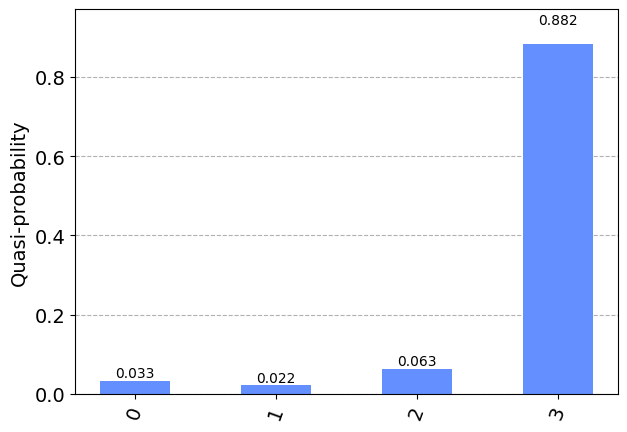

In [14]:
from qiskit.visualization import plot_histogram
result = Sampler().run(qc).result()
plot_histogram(result.quasi_dists)

In [15]:
most_probable = max(result.quasi_dists[0],
                    key=result.quasi_dists[0].get)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 3
Estimated theta: 0.75


### Implementacion para multiples qubits

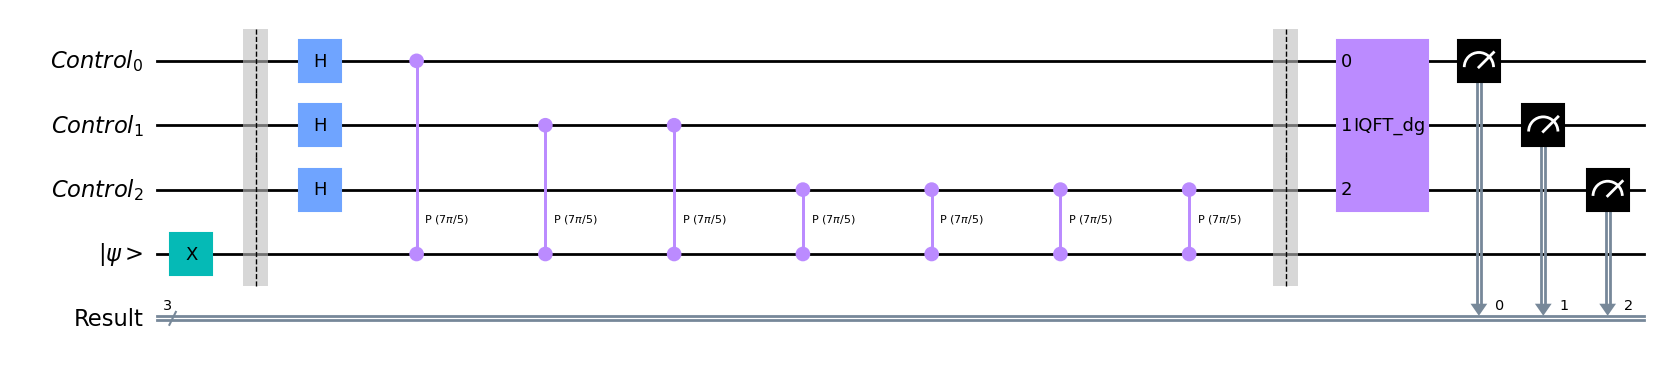

In [22]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

theta = .7
m = 3 # Number of control qubits

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

# Prepare the eigenvector |ψ>
qc.x(target_register)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2*pi*theta, qubit, target_register)
qc.barrier()

# Do inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True),
    inplace=True
)

# Measure everything
qc.measure(range(m), range(m))
qc.draw(output="mpl")

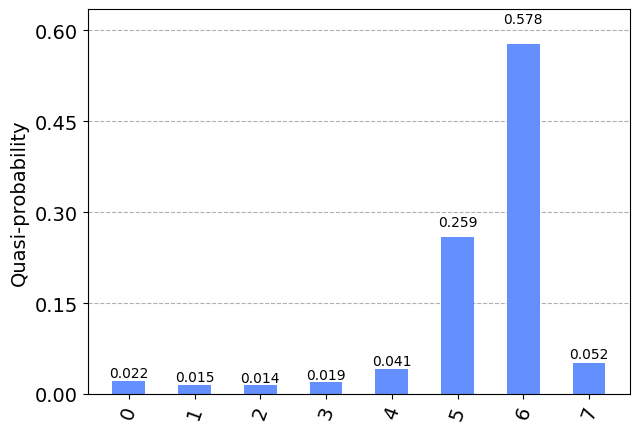

In [23]:
result = Sampler().run(qc).result()
plot_histogram(result.quasi_dists)

In [24]:
most_probable = max(result.quasi_dists[0],
                    key=result.quasi_dists[0].get)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 6
Estimated theta: 0.75
